**# STEP 1: IMPORT NECESSARY LIBRARIES**

In [1]:
import pandas as pd    #Data manipulation and analysis
import matplotlib.pyplot as plt    #Visualization
# Data preprocessing using NLP
import nltk
nltk.download('punkt')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder   #Converting categorical intensity levels into numerical format
from sklearn.feature_extraction.text import TfidfVectorizer    #Text vectorization
from sklearn.model_selection import train_test_split    #Train test split
from imblearn.under_sampling import RandomUnderSampler  #Resampling data using Undersampling
# Model Selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold   #Hyperparameter tuning & Cross-validation
from sklearn.metrics import accuracy_score, classification_report     #Measuring accuracy & generating a classification report
import joblib    #Saving and Loading Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**STEP 2 : DATA EXPLORATION**


Data Collection

In [2]:
# Load happiness, sadness and angriness intensity level dataset
happiness_df = pd.read_csv('happiness.csv')
sadness_df = pd.read_csv('sadness.csv')
angriness_df = pd.read_csv('angriness.csv')

In [3]:
# Check the first 2 rows of each DataFrames & shape
print("Happiness DataFrame:")
happiness_df.head(), happiness_df.shape

print("\nSadness DataFrame:")
print(sadness_df.head())
print(sadness_df.shape)

print("\nAngriness DataFrame:")
print(angriness_df.head())
print(angriness_df.shape)

Happiness DataFrame:

Sadness DataFrame:
                                             content intensity
0  Never hurt people who love you a lot, because ...   sadness
1  Don’t expect me to tell you what you did wrong...   sadness
2  I preferred walking away than fighting for you...   sadness
3  Moving forward in life isn’t the hard part, it...   sadness
4  Never cry for anyone in your life, because tho...   sadness
(635, 2)

Angriness DataFrame:
                                             content  intensity
0  Sometimes I’m not angry, I’m hurt and there’s ...  angriness
1                     Not available for busy people☺  angriness
2  I do not exist to impress the world. I exist t...  angriness
3  Everything is getting expensive except some pe...  angriness
4       My phone screen is brighter than my future 🙁  angriness
(696, 2)


In [4]:
# Combine the all 3 intensity level datasets
df = pd.concat([happiness_df, angriness_df, sadness_df], ignore_index=True)

In [5]:
# print the first 5 rows from the final dataframe dataset
df.head()

,content,intensity
0,Wants to know how the hell I can remember word...,happiness
1,Love is a long sweet dream & marriage is an al...,happiness
2,The world could be amazing when you are slight...,happiness
3,My secret talent is getting tired without doin...,happiness
4,"Khatarnaak Whatsapp Status Ever… Can\’t talk, ...",happiness


In [6]:
#print the last 5 rows from the dataset
df.tail()

,content,intensity
2034,Stop crying over yesterday and start smiling f...,sadness
2035,An Eye with Dust ‘n A Heart with Trust Always ...,sadness
2036,Tears come from the heart and not from the brain.,sadness
2037,"Sometimes you have to hold your head up high, ...",sadness
2038,"Instead of wiping your tears, wipe away the pe...",sadness


In [7]:
# print the size of rows & columns
df.shape

(2039, 2)

In [8]:
# print the summary of dataset(like: data types, non-null values, and memory usage)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2039 non-null   object
 1   intensity  2039 non-null   object
dtypes: object(2)
memory usage: 32.0+ KB


We can observe that both content and intensity columns have Object data types, 2039 non-null entries and DataFrame is using 32.0+ kilobytes of memory.

In [9]:
#checking null values
df.isnull().sum()

content      0
intensity    0
dtype: int64

No Null Values found.

In [10]:
#check for any duplicate text content
len(df['content'])-len(df['content'].drop_duplicates())

453

453 contents are duplicates.

In [11]:
# Drop duplicates
df = df.drop_duplicates(subset=['content'], keep='first')

We can drop the duplicates.

In [12]:
# Final dataset shape
df.shape

(1586, 2)

Now our final datatset having 1586 rows and 2 columns

**Visualization for Categorical data**

Text(0.5, 1.0, 'Distribution of Intensity')

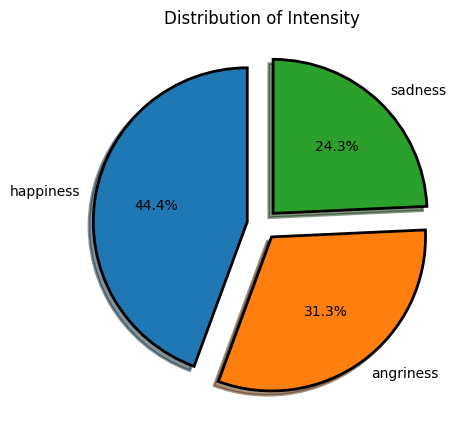

In [13]:
# Visualization of Categorical data (Intensity)
fig = plt.figure(figsize=(5,5))
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['intensity'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of Intensity')

We observed that intensity distributed in 3 levels, happiness: 44.4% , Sadness: 24.3% and Angriness: 31.3% which means our Intensity levels are imbalanced so we need to deal with using resampling.

**Plot Distribution based on the length of the content for each intensity**

In [14]:
#check for the length of text contents
df['length']= df['content'].apply(lambda x: len(x.split(' ')))

In [15]:
#print avg. length of intensity for text contents
print("Happiness text content lnegth is:", round(df[df['intensity']=='happiness']['length'].mean()))
print("Angriness text content lnegth is:", round(df[df['intensity']=='angriness']['length'].mean()))
print("Sadness text content lnegth is:", round(df[df['intensity']=='sadness']['length'].mean()))

Happiness text content lnegth is: 13
Angriness text content lnegth is: 17
Sadness text content lnegth is: 20


In [16]:
df.head()

,content,intensity,length
0,Wants to know how the hell I can remember word...,happiness,26
1,Love is a long sweet dream & marriage is an al...,happiness,12
2,The world could be amazing when you are slight...,happiness,10
3,My secret talent is getting tired without doin...,happiness,10
4,"Khatarnaak Whatsapp Status Ever… Can\’t talk, ...",happiness,8


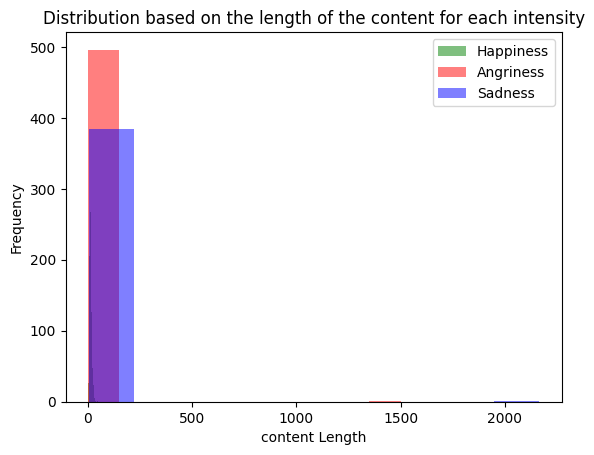

In [17]:
# plot the distribution based on the length of the content for each intensity
plt.hist(df[df['intensity']=='happiness']['length'], bins=10, alpha=0.5, label='Happiness', color='green')
plt.hist(df[df['intensity']=='angriness']['length'], bins=10, alpha=0.5, label='Angriness', color='red')
plt.hist(df[df['intensity']=='sadness']['length'], bins=10, alpha=0.5, label='Sadness', color='blue')

# Add labels and legend
plt.xlabel('content Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution based on the length of the content for each intensity')

# Show the plot
plt.show()

**STEP 3: DATA CLEANING AND TOKENIZATION USING NLP**

In [18]:
# Text cleaning and tokenization
def preprocess_text(content):
    # Convert to lowercase
    content = content.lower()
    # Remove special characters, emojis, and unwanted symbols
    content = re.sub(r'[^a-zA-Z0-9\s]', '', content)
    # remove special characters and punctuations
    content = re.sub(r'\W', ' ', content)
    # remove single characters except for 'a' and 'i'
    content = re.sub(r'\s+[a-hj-z]\s+', ' ', content)
    content = re.sub(r'\s+i\s+', ' I ', content)
    content = re.sub(r'\s+a\s+', ' a ', content)
    # substitute multiple spaces with single space
    content = re.sub(r'\s+', ' ', content, flags=re.I)
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    # Tokenization
    words = nltk.word_tokenize(content)

    # Remove stop words and perform stemming
    words = [ps.stem(word) for word in words if word.isalnum() and word not in stop_words]

    return ' '.join(words)

In [19]:
# Apply text preprocessing to the 'content' column
df['processed_text'] = df['content'].apply(preprocess_text)

In [20]:
# print the first 5 rows from the dataset
df

,content,intensity,length,processed_text
0,Wants to know how the hell I can remember word...,happiness,26,want know hell i rememb word song year ago can...
1,Love is a long sweet dream & marriage is an al...,happiness,12,love long sweet dream marriag alarm clock
2,The world could be amazing when you are slight...,happiness,10,world could amaz slightli strang
3,My secret talent is getting tired without doin...,happiness,10,secret talent get tire without anyth
4,"Khatarnaak Whatsapp Status Ever… Can\’t talk, ...",happiness,8,khatarnaak whatsapp statu ever cant talk wife ...
...,...,...,...,...
2034,Stop crying over yesterday and start smiling f...,sadness,9,stop cri yesterday start smile tomorrow
2035,An Eye with Dust ‘n A Heart with Trust Always ...,sadness,11,eye dust heart trust alway cri
2036,Tears come from the heart and not from the brain.,sadness,10,tear come heart brain
2037,"Sometimes you have to hold your head up high, ...",sadness,16,sometim hold head high blink away tear say goodby


In [21]:
#calculate updated length of intensity for text content after removing the stopwords and cleaning content
df['new_length']=df['processed_text'].apply(lambda x: len(x.split(" ")))

In [22]:
#print updated avg length of intensity for text content after removing the stopwords and cleaning content
print("Happiness text content lnegth after preprocessing:", round(df[df['intensity']=='happiness']['new_length'].mean()))
print("Angriness text content lnegth after preprocessing:", round(df[df['intensity']=='angriness']['new_length'].mean()))
print("Sadness text content lnegth after preprocessing:", round(df[df['intensity']=='sadness']['new_length'].mean()))

Happiness text content lnegth after preprocessing: 7
Angriness text content lnegth after preprocessing: 9
Sadness text content lnegth after preprocessing: 10


In [23]:
df.head()

,content,intensity,length,processed_text,new_length
0,Wants to know how the hell I can remember word...,happiness,26,want know hell i rememb word song year ago can...,15
1,Love is a long sweet dream & marriage is an al...,happiness,12,love long sweet dream marriag alarm clock,7
2,The world could be amazing when you are slight...,happiness,10,world could amaz slightli strang,5
3,My secret talent is getting tired without doin...,happiness,10,secret talent get tire without anyth,6
4,"Khatarnaak Whatsapp Status Ever… Can\’t talk, ...",happiness,8,khatarnaak whatsapp statu ever cant talk wife ...,8


**Plot Distribution based on the length of the content for each intensity after text content preprocessing**

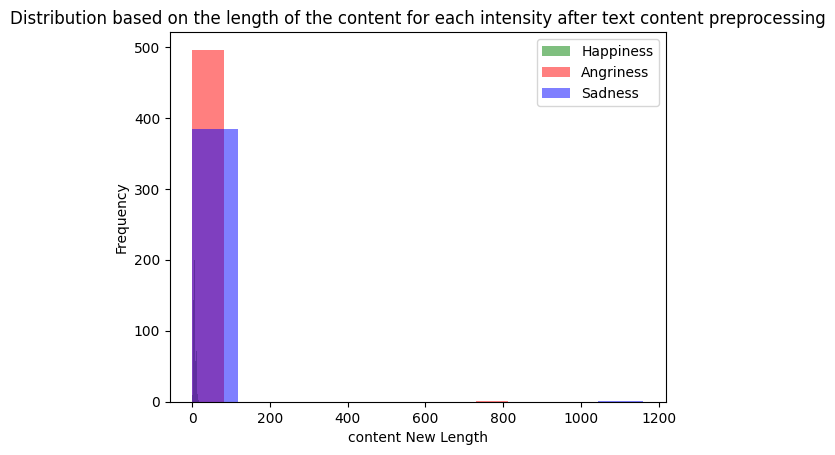

In [24]:
#plot the distribution based on the length of the content for each intensity
plt.hist(df[df['intensity']=='happiness']['new_length'], bins=10, alpha=0.5, label='Happiness', color='green')
plt.hist(df[df['intensity']=='angriness']['new_length'], bins=10, alpha=0.5, label='Angriness', color='red')
plt.hist(df[df['intensity']=='sadness']['new_length'], bins=10, alpha=0.5, label='Sadness', color='blue')

# Add labels and legend
plt.xlabel('content New Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution based on the length of the content for each intensity after text content preprocessing')

# Show the plot
plt.show()

**STEP 4: FEATURE ENGINEERING**

In [25]:
#converting categorical intensity levels into numerical format
label_encoder = LabelEncoder()
df['intensity_encoded'] = label_encoder.fit_transform(df['intensity'])

In [26]:
# check the intensity encoded or not
df = df[['processed_text', 'intensity', 'intensity_encoded']]
df

,processed_text,intensity,intensity_encoded
0,want know hell i rememb word song year ago can...,happiness,1
1,love long sweet dream marriag alarm clock,happiness,1
2,world could amaz slightli strang,happiness,1
3,secret talent get tire without anyth,happiness,1
4,khatarnaak whatsapp statu ever cant talk wife ...,happiness,1
...,...,...,...
2034,stop cri yesterday start smile tomorrow,sadness,2
2035,eye dust heart trust alway cri,sadness,2
2036,tear come heart brain,sadness,2
2037,sometim hold head high blink away tear say goodby,sadness,2


We can see that our intensity levels encoded as follows: happiness encoded as 1, angriness encoded as 0 and sadness encoded as 2.

In [27]:
#feature selection
X = df['processed_text']
y = df['intensity_encoded']

**STEP 5: DEALING WITH IMBALANCED DATASET USING UNDERSAMPLING**

In [28]:
#Define the Undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

#Reshape X to a 1D array (necessary for undersampling)
X_reshaped = X.values.reshape(-1, 1)

#fit the Undersample in X & y
X_resampled, y_resampled = undersampler.fit_resample(X_reshaped, y)

# Convert X back to a Series
X_resampled = pd.Series(X_resampled.flatten())

Text(0.5, 1.0, 'After resampling: Distribution of Intensity')

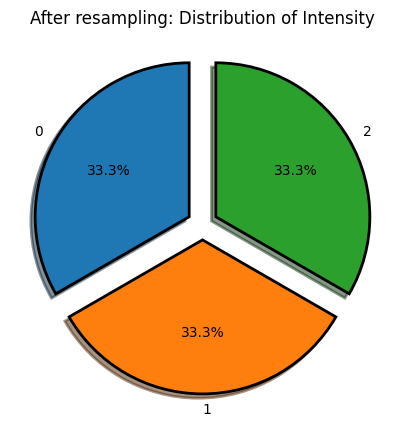

In [29]:
# Visualization of resampled Intensity levels
fig = plt.figure(figsize=(5,5))
wp = {'linewidth':2, 'edgecolor':"black"}
tags = y_resampled.value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('After resampling: Distribution of Intensity')

Now Intensity levels are equally distributed as 33.3% which means our intensity levels are balanced.

**STEP 6: TF-IDF Vectorization**

In [30]:
#TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

#Fit and transform on the undersampled data
X_tfidf = tfidf_vectorizer.fit_transform(X_resampled)

**Train/Test Split**

In [31]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_resampled, test_size=0.2, random_state=42)


In [32]:
#Print the shape of X, y train & test dataset
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((924, 1577), (231, 1577), (924,), (231,))

**STEP 7: MODEL DEVELOPMENT AND EVALUATION**

In [33]:
#Define Machine Learning Models
models = {
      'Logistic Regression' :LogisticRegression(),
      'Random Forest': RandomForestClassifier(),
      'SVM': SVC(),
      'Naive Bayes': MultinomialNB(),
      'XGB': XGBClassifier(),
      'KNN': KNeighborsClassifier(n_neighbors=5)
}

**STEP 8: HYPERPARAMETER TUNING & CROSS VALIDATION FOR MODEL IMPROVEMENT**

In [34]:
#Define Hyperparameter using GridSearchCV
hyperparameters = {
    'Logistic Regression' : {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Naive Bayes': {'alpha': [0.1, 0.5, 1.0]},
    'XGB' :{'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
}

In [35]:
#define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [36]:

# Create an empty list to store results
results_list = []

# Train and Evaluate Models
for models_name, model in models.items():
    print(f"\nTraining and evaluating {models_name}...")

    # Apply Hyperparameter tuning & cross validation
    grid_search = GridSearchCV(model, hyperparameters[models_name],cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters for {models_name}: {best_params}")

    # Updated model with best hyperparameters
    best_model = grid_search.best_estimator_

    # Training Accuracy
    train_predictions = best_model.predict(X_train)
    train_accuracy = "{:.3f}".format(accuracy_score(y_train, train_predictions))
    print(f"{models_name} Training Accuracy: {train_accuracy}")

    # Test Accuracy
    test_predictions = best_model.predict(X_test)
    test_accuracy = "{:.3f}".format(accuracy_score(y_test, test_predictions))
    print(f"{models_name} Test Accuracy: {test_accuracy}")

    # Display classification report for test set
    print(f"Classification Report for {models_name} (Test Set):")
    print(classification_report(y_test, test_predictions))

    # Append results to the list
    results_list.append({
        'Model Name': models_name,
        'Training Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Best Hyperparameters': best_params,
        'Model': best_model
    })


Training and evaluating Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Hyperparameters for Logistic Regression: {'C': 1}
Logistic Regression Training Accuracy: 0.920
Logistic Regression Test Accuracy: 0.697
Classification Report for Logistic Regression (Test Set):
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        81
           1       0.71      0.71      0.71        77
           2       0.71      0.58      0.64        73

    accuracy                           0.70       231
   macro avg       0.70      0.69      0.69       231
weighted avg       0.70      0.70      0.69       231


Training and evaluating Random Forest...
Best Hyperparameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Random Forest Training Accuracy: 0.859
Random Forest Test Accuracy: 0.619
Classification Report for Random Forest (Test Set):
              precision    recall  f1-score   support

           0       0.63      0.65      0.64        81
           1       0.57      0.65      0.61        77
          

**Model Comparison Matrix**

In [37]:
# Convert the list to a DataFrame
results_df = pd.DataFrame(results_list)

# Sort the DataFrame by training & testing accuracy in descending order
results_df_sorted = results_df.sort_values(by=['Training Accuracy','Test Accuracy'], ascending=False)

# Display the Model comparison matrix
print("Model Comparison Matrix:")

# Display the sorted DataFrame
results_df_sorted


Model Comparison Matrix:


,Model Name,Training Accuracy,Test Accuracy,Best Hyperparameters,Model
2,SVM,0.998,0.701,"{'C': 10, 'kernel': 'rbf'}",SVC(C=10)
5,KNN,0.998,0.636,"{'n_neighbors': 7, 'weights': 'distance'}","KNeighborsClassifier(n_neighbors=7, weights='d..."
4,XGB,0.974,0.662,"{'learning_rate': 0.2, 'max_depth': 7}","XGBClassifier(base_score=None, booster=None, c..."
0,Logistic Regression,0.920,0.697,{'C': 1},LogisticRegression(C=1)
3,Naive Bayes,0.897,0.658,{'alpha': 1.0},MultinomialNB()
1,Random Forest,0.859,0.619,"{'max_depth': 10, 'n_estimators': 100}","(DecisionTreeClassifier(max_depth=10, max_feat..."


We can observe clearly from our model comparison matrix that SVM & KNN both models got highest training accuracy: 99.8% but SVM model got 70.1% testing accuracy while KNN got 63.6% testing accuracy so we can say SVM is best model for us.

**STEP 9: SAVING THE MODEL**

In [38]:
# save the best model besed on Training & testing accuracy
best_model = results_df_sorted.iloc[0]['Model']
best_model_name = results_df_sorted.iloc[0]['Model Name']
best_model_path = f'{best_model_name}_best_model.joblib'
joblib.dump(best_model, best_model_path)
print(f"\nBest Model ({best_model_name}) saved successfully at: {best_model_path}")

# Save the TF-IDF vectorizer
tfidf_vectorizer_path = 'intensity_tfidf_vectorizer.joblib'
joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
print(f"TF-IDF Vectorizer saved successfully at: {tfidf_vectorizer_path}")


Best Model (SVM) saved successfully at: SVM_best_model.joblib
TF-IDF Vectorizer saved successfully at: intensity_tfidf_vectorizer.joblib


**STEP 10: TEST & VALIDATE THE MODEL**

In [39]:
# Load the saved model and TF-IDF vectorizer
loaded_model = joblib.load('SVM_best_model.joblib')
loaded_tfidf_vectorizer = joblib.load('intensity_tfidf_vectorizer.joblib')


# List of sentences to predict sentiment for
Text_Contents_to_predict = [
    "Frustration welled up within her, boiling over into a torrent of anger. The clenched fists and furrowed brow betrayed the intensity of her emotions as harsh words erupted like a storm, leaving a tense atmosphere in their wake.",
    "In the quiet solitude of the dimly lit room, she clutched an old photograph, tears streaming down her face as she reminisced about a lost friendship.",
    "Surrounded by loved ones, the laughter and joy at the birthday party echoed in the air, creating a warm and uplifting atmosphere.",
    "The slammed door echoed through the house, a resounding punctuation to a heated argument. The seething anger lingered in the air, leaving both parties in an uneasy silence, grappling with the aftermath of emotions unleashed.",
    "Sunlight streamed through the window, casting a warm glow on the family gathered around the table. Smiles exchanged during a shared meal created a tapestry of happiness, bonding them together in a moment of simple, yet profound, familial bliss.",
    "A contagious joy radiated from his infectious smile, illuminating the room with warmth.",
    "The air crackled with tension as his face reddened, betraying the escalating anger within. Sharp words and accusations flew like daggers, leaving behind a bitter residue that lingered in the strained silence, a testament to the intensity of the emotional tempest.",
    " In the dimly lit room, a solitary figure sat hunched over, shoulders weighed down by the burden of grief. Silent tears traced a delicate path down worn cheeks, a poignant expression of the profound sadness that cast a shadow over the once-lively space.",
    "Fists clenched, she paced the room, the rapid tapping of her foot mirroring the fiery frustration burning within. The harsh words exchanged reverberated in the charged air, leaving a bitter taste of resentment that hung heavily between them.",
    " A surprise birthday party unfolded, complete with confetti, balloons, and the contagious joy of celebration. Faces lit up with delight, and the air buzzed with the harmonious symphony of well-wishes, creating an atmosphere saturated with the happiness of shared love and camaraderie.",
    "The gray clouds mirrored the heaviness in her heart as she stood alone in the rain. Each raindrop seemed to echo the rhythm of her sorrow, providing a somber backdrop to the emotional storm within, a silent manifestation of a world painted in shades of sadness."
]

# Create an empty list to store results
results_list = []

# Iterate through text contents and predict intensity
for sentence in Text_Contents_to_predict:
    # Preprocess the new text
    cleaned_text = preprocess_text(sentence)
    preprocessed_text = preprocess_text(cleaned_text)

    # Transform the preprocessed text using the loaded TF-IDF vectorizer
    X_new = loaded_tfidf_vectorizer.transform([preprocessed_text])

    # Make predictions using the loaded model
    new_text_prediction = loaded_model.predict(X_new)

    # Convert the predicted label back to the original class label if needed
    predicted_label = label_encoder.inverse_transform(new_text_prediction)

    # Append results to the list
    results_list.append({
        'Text Content': sentence,
        'Predicted Intensity': predicted_label[0]
    })

# Display the results
for result in results_list:
    print(f"Text Content: {result['Text Content']}")
    print(f"Predicted Intensity: {result['Predicted Intensity']}\n")

Text Content: Frustration welled up within her, boiling over into a torrent of anger. The clenched fists and furrowed brow betrayed the intensity of her emotions as harsh words erupted like a storm, leaving a tense atmosphere in their wake.
Predicted Intensity: angriness

Text Content: In the quiet solitude of the dimly lit room, she clutched an old photograph, tears streaming down her face as she reminisced about a lost friendship.
Predicted Intensity: sadness

Text Content: Surrounded by loved ones, the laughter and joy at the birthday party echoed in the air, creating a warm and uplifting atmosphere.
Predicted Intensity: happiness

Text Content: The slammed door echoed through the house, a resounding punctuation to a heated argument. The seething anger lingered in the air, leaving both parties in an uneasy silence, grappling with the aftermath of emotions unleashed.
Predicted Intensity: angriness

Text Content: Sunlight streamed through the window, casting a warm glow on the family 

**STEP 11: Save the final predicted sentiments along with text content to CSV File**

In [40]:
# Save the final predicted sentiments along with text content to a DataFrame
results_df = pd.DataFrame(results_list)

# Save the DataFrame to a CSV file or any other desired format
results_df.to_csv('Predicted_Intensity.csv', index=False)

#Ensuring the CSV was created as expected
df= pd.read_csv('Predicted_Intensity.csv')
df

,Text Content,Predicted Intensity
0,"Frustration welled up within her, boiling over...",angriness
1,"In the quiet solitude of the dimly lit room, s...",sadness
2,"Surrounded by loved ones, the laughter and joy...",happiness
3,"The slammed door echoed through the house, a r...",angriness
4,"Sunlight streamed through the window, casting ...",happiness
5,A contagious joy radiated from his infectious ...,happiness
6,The air crackled with tension as his face redd...,angriness
7,"In the dimly lit room, a solitary figure sat ...",sadness
8,"Fists clenched, she paced the room, the rapid ...",happiness
9,"A surprise birthday party unfolded, complete ...",happiness
